### build dataset

In [1]:
import csv
from pathlib import Path
import numpy as np
import tensorflow as tf
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

def expand_row_data(data, capture_point) -> tuple[np.ndarray, np.ndarray]:

    label = []
    expand_data = []

    for idx in range(1, len(data), capture_point):
        label.append(int(data[0]))
        expand_data.append(np.array(data[idx : idx + capture_point], dtype=np.float32))

    return label, expand_data

def gen_tf_dataset(data, capture_point, batch_size, output_class):
    label = []
    expanded_data = []
    for row in data:
        l, e = expand_row_data(row, capture_point)    
        
        label += l
        expanded_data += e
    label = tf.one_hot(label, output_class)  
    
    dataset = tf.data.Dataset.from_tensor_slices((expanded_data, label))
    dataset = dataset.shuffle(len(data), reshuffle_each_iteration=True)
    dataset = dataset.cache()
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return dataset

def dataset_preproccessed(data_folder, batch_size, train_vaild_test_ratio, output_class):
    data_folder = Path(data_folder)
    capture_point, extra_point = data_folder.stem.split('_')[:-1]
    capture_point = int(capture_point[1:])
    extra_point = int(extra_point[1:])

    
    with open(data_folder, newline='') as data:
        row_data = csv.reader(data, delimiter=',')
        row_data = [i for i in row_data]

    random.shuffle(row_data)
    
    train_data_cnt = int(len(row_data) * train_vaild_test_ratio[0])
    valid_data_cnt = int(len(row_data) * train_vaild_test_ratio[1])
    test_data_cnt = len(row_data) - train_data_cnt - valid_data_cnt
    print(capture_point, extra_point)
    print(train_data_cnt, valid_data_cnt, test_data_cnt)
    
    for idx, row in enumerate(row_data):
        for c_idx, _ in enumerate(row): 
            row_data[idx][c_idx] = float(row[c_idx])
            if c_idx % 6 < 3 : row_data[idx][c_idx] = (row_data[idx][c_idx] + 4.0) / 8.0
            else: row_data[idx][c_idx] = (row_data[idx][c_idx] + 2000.0) / 4000.0

    train_dataset = gen_tf_dataset(row_data[:train_data_cnt], capture_point, batch_size, output_class)
    valid_dataset = gen_tf_dataset(row_data[train_data_cnt : train_data_cnt + valid_data_cnt], capture_point, batch_size, output_class)
    test_dataset = gen_tf_dataset(row_data[train_data_cnt + valid_data_cnt : ], capture_point, batch_size, output_class)
    
    return capture_point, train_dataset, valid_dataset, test_dataset




2024-06-07 11:09:27.136834: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 11:09:27.865899: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 11:09:27.866120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 11:09:28.004774: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-07 11:09:28.286971: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 11:09:28.290319: I tensorflow/core/platform/cpu_feature_guard.cc:1

### pseudo dataset

In [2]:
def gen_pseudo_dataset(size, capture_point, batch_size, output_class):
    label = []
    expanded_data = []

    x_values = np.random.uniform(low=0, high= output_class * 1000, size=size).astype(np.float32)

    for x in x_values:
        l = int(x // 1000) 

        e = [l for i in range(capture_point)]

        label += [l]
        expanded_data += [e]
    label = tf.one_hot(label, output_class)  
    
    dataset = tf.data.Dataset.from_tensor_slices((expanded_data, label))
    dataset = dataset.shuffle(size, reshuffle_each_iteration=True)
    dataset = dataset.cache()
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return dataset

def pseudo_dataset_preproccessed(total_data_size ,capture_point, batch_size, train_vaild_test_ratio, output_class):

    
    train_data_cnt = int(total_data_size * train_vaild_test_ratio[0])
    valid_data_cnt = int(total_data_size * train_vaild_test_ratio[1])
    test_data_cnt = total_data_size- train_data_cnt - valid_data_cnt
    print(capture_point)
    print(train_data_cnt, valid_data_cnt, test_data_cnt)

    train_dataset = gen_pseudo_dataset(train_data_cnt, capture_point, batch_size, output_class)
    valid_dataset = gen_pseudo_dataset(valid_data_cnt, capture_point, batch_size, output_class)
    test_dataset = gen_pseudo_dataset(test_data_cnt, capture_point, batch_size, output_class)
    
    return capture_point, train_dataset, valid_dataset, test_dataset

### define model

In [3]:
class model(tf.keras.Model):
    def __init__(self , input_dim , out_class = 9 , learning_rate=1e-3):
        super().__init__()
        self.input_dim = input_dim
        self.out_class = out_class
        self.learning_rate = learning_rate

        self._model = self._build_model()
        self._learner = self._build_learner()
    
    @tf.function
    def call(self, x:tf.Tensor, training:bool=False) -> tf.Tensor:
        output = self._model(x, training=training)
        return output
    
    @tf.function
    def train(self, x:tf.Tensor, y:tf.Tensor):
        with tf.GradientTape() as tape:
            output = self.__call__(x, training=True)
            classLoss = self._learner["get_loss"](y, output)
            review = tf.math.in_top_k(tf.math.argmax(y,axis=1), output, 1)
            perf = tf.math.reduce_mean(tf.cast(review, dtype="float32"))

        cGradients = tape.gradient(classLoss, self._model.trainable_variables)
        self._learner["optimize"].apply_gradients(zip(cGradients, self._model.trainable_variables))
        return perf, classLoss


    @tf.function
    def validate(self, x:tf.Tensor, y:tf.Tensor) -> tf.Tensor:
        output = self.__call__(x, training=False)
        classLoss = self._learner["get_loss"](y , output)
        review = tf.math.in_top_k(tf.math.argmax(y,axis=1), output, 1)
        perf = tf.math.reduce_mean(tf.cast(review, dtype="float32"))
        return perf , classLoss

    def _build_model(self) -> tf.keras.Model:

        input_tensor = tf.keras.Input(shape=self.input_dim)
        feature_map = input_tensor
        
        d = 128
        feature_map = tf.keras.layers.Dense(d, input_dim = self.input_dim, activation='relu')(feature_map)
        feature_map = tf.keras.layers.Dropout(0.1)(feature_map)
        # feature_map = tf.keras.layers.Dense(d//4, input_dim = d, activation='relu')(feature_map)
        feature_map = tf.keras.layers.Dropout(0.1)(feature_map)
        output_tensor = tf.keras.layers.Dense(self.out_class, input_dim = d, activation=tf.keras.activations.softmax)(feature_map)
        

        model = tf.keras.Model(input_tensor, output_tensor)
        return model
    
    def _build_learner(self) -> dict:
        # classLoss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        classLoss = tf.keras.losses.CategoricalCrossentropy()
        classOptimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        learner = {"get_loss": classLoss, "optimize": classOptimizer}

        return learner

### train

In [4]:
def train_one_epoch(model , train_dataloader , valid_dataloader , max_acc , root_dir : Path):

    epoch_train_loss = []
    epoch_train_acc = []
    epoch_valid_loss = []
    epoch_valid_acc = []

    for inData, outData in train_dataloader:
        acc , loss = model.train(inData, outData)
        epoch_train_acc.append(acc)
        epoch_train_loss.append(loss)
        # print(loss)
        # print(acc)
    # raise ValueError
        
    for inData, outData in valid_dataloader:
        acc , loss = model.validate(inData, outData)
        epoch_valid_acc.append(acc)
        epoch_valid_loss.append(loss)

    epoch_train_acc_mean = tf.math.reduce_mean(epoch_train_acc) * 100
    epoch_valid_acc_mean = tf.math.reduce_mean(epoch_valid_acc) * 100
    epoch_train_loss_mean = tf.math.reduce_mean(epoch_train_loss)
    epoch_valid_loss_mean = tf.math.reduce_mean(epoch_valid_loss)

    print(f"  Train Acc: {epoch_train_acc_mean:.2f}, Loss: {epoch_train_loss_mean:.2f}")
    print(f"  Valid Acc: {epoch_valid_acc_mean:.2f}, Loss: {epoch_valid_loss_mean:.2f}")

    if(epoch_valid_acc_mean > max_acc):
        print("save best model")
        model.save(root_dir /"model", include_optimizer=False)
    
    return epoch_train_acc_mean, epoch_train_loss_mean , epoch_valid_acc_mean , epoch_valid_loss_mean


In [5]:
def testing_model(test_dataloader , root_dir : Path = None , model_path : Path = None):
    if root_dir is not None :
        model = tf.keras.models.load_model(root_dir / "model", compile=False)
    elif model_path is not None:
        model = tf.keras.models.load_model(model_path)
    else:
        raise AttributeError("Testing models root_dir and model_path are not given")
    
    testing_acc = []
    print("Testing Model")
    
    for data , label in tqdm(test_dataloader):
        acc , loss = model.validate(data , label)
        
        testing_acc.append(acc)
    
    print(f"acc = {np.mean(testing_acc)*100:.2f}")
    del model

In [6]:
def show_train_results(train_info , root_folder : Path):
    train_info = np.array(train_info)

    plt.plot(np.arange(1,train_info.shape[0]+1) , train_info[:,0] , 'r' , label='train')
    plt.plot(np.arange(1,train_info.shape[0]+1) , train_info[:,2] , 'b' , label='valid')
    plt.title("Acc")
    plt.savefig(root_folder / "model" / "Acc.png")
    plt.show()

    plt.plot(np.arange(1,train_info.shape[0]+1) , train_info[:,1] , 'r' , label='train')
    plt.plot(np.arange(1,train_info.shape[0]+1) , train_info[:,3] , 'b' , label='valid')
    plt.title("Loss")
    plt.savefig(root_folder / "model" / "Loss.png")
    plt.show()

### convert model

In [7]:
def save_model_tflite_quant(save_model_folder : Path , dataset):

    def representative_dataset():
        idx = 0
        for data , label in dataset:
            if idx > 1000:
                break
            idx += 1
            
            yield [data]

    # float
    converter = tf.lite.TFLiteConverter.from_saved_model(str(save_model_folder))
    tflite_model = converter.convert()
    open(save_model_folder / 'float_model.tflite', 'wb').write(tflite_model)
    print("Successfully convert tflite float")

    # quant
    converter = tf.lite.TFLiteConverter.from_saved_model(str(save_model_folder))
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8  # or tf.uint8
    converter.inference_output_type = tf.int8  # or tf.uint8
    tflite_quant_model = converter.convert()
    open(save_model_folder / 'quant_model.tflite', 'wb').write(tflite_quant_model)
    print("Successfully convert tflite quant")

In [8]:
def test_tflite_model(tflite_model_path, test_dataset):
    interpreter = tf.lite.Interpreter(model_path=str(tflite_model_path))
    interpreter.allocate_tensors()
    input = interpreter.get_input_details()[0]
    output = interpreter.get_output_details()[0]
    input_scale, input_zero_point = input['quantization']
    output_scale, output_zero_point = output["quantization"]
    
    print(f"testing with {tflite_model_path}")
    
    testing_acc = np.array([])
    for data , label in tqdm(test_dataset):
        if input["dtype"] == np.float32:
            interpreter.set_tensor(input['index'], data)
        else:
            quant_data = data.numpy() / input_scale + input_zero_point
            interpreter.set_tensor(input['index'], quant_data.astype(input["dtype"] ))

        interpreter.invoke()

        if output["dtype"] == np.float32:
            pred = interpreter.get_tensor(output['index'])
        else:
            dequant_pred = interpreter.get_tensor(output['index']).astype(np.float32)
            pred = (dequant_pred - output_zero_point) * output_scale

        testing_acc = np.append(testing_acc, np.argmax(pred) == np.argmax(label))   
    
    print(f"result acc = {np.mean(testing_acc)*100:.2f}")


### main func

30 5
252 14 14


2024-06-07 11:09:33.640297: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 128)               3968      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 4871 (19.03 KB)
Trainable params: 4871 (19.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
  Train Acc: 63.05, Loss:

INFO:tensorflow:Assets written to: model/assets


  Train Acc: 64.88, Loss: 0.62
  Valid Acc: 37.50, Loss: 0.83
  Train Acc: 65.18, Loss: 0.61
  Valid Acc: 40.18, Loss: 0.84
save best model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


  Train Acc: 66.22, Loss: 0.61
  Valid Acc: 38.39, Loss: 0.84
  Train Acc: 66.57, Loss: 0.60
  Valid Acc: 54.46, Loss: 0.81
save best model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


  Train Acc: 66.42, Loss: 0.60
  Valid Acc: 37.50, Loss: 0.83
  Train Acc: 66.32, Loss: 0.60
  Valid Acc: 53.57, Loss: 0.80
  Train Acc: 66.52, Loss: 0.59
  Valid Acc: 52.68, Loss: 0.81
  Train Acc: 67.01, Loss: 0.59
  Valid Acc: 58.93, Loss: 0.80
save best model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


  Train Acc: 66.96, Loss: 0.59
  Valid Acc: 60.71, Loss: 0.78
save best model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


  Train Acc: 67.36, Loss: 0.59
  Valid Acc: 61.61, Loss: 0.78
save best model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


  Train Acc: 67.51, Loss: 0.59
  Valid Acc: 56.25, Loss: 0.80
  Train Acc: 66.87, Loss: 0.59
  Valid Acc: 61.61, Loss: 0.79
  Train Acc: 67.51, Loss: 0.59
  Valid Acc: 62.50, Loss: 0.78
save best model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


  Train Acc: 66.77, Loss: 0.59
  Valid Acc: 60.71, Loss: 0.79
  Train Acc: 67.26, Loss: 0.58
  Valid Acc: 59.82, Loss: 0.80
  Train Acc: 67.36, Loss: 0.58
  Valid Acc: 59.82, Loss: 0.79
  Train Acc: 67.71, Loss: 0.58
  Valid Acc: 63.39, Loss: 0.77
save best model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


  Train Acc: 67.76, Loss: 0.58
  Valid Acc: 62.50, Loss: 0.78
  Train Acc: 67.66, Loss: 0.59
  Valid Acc: 63.39, Loss: 0.77
  Train Acc: 68.35, Loss: 0.58
  Valid Acc: 61.61, Loss: 0.79
  Train Acc: 67.61, Loss: 0.58
  Valid Acc: 62.50, Loss: 0.79
  Train Acc: 68.06, Loss: 0.58
  Valid Acc: 62.50, Loss: 0.79
  Train Acc: 68.15, Loss: 0.58
  Valid Acc: 61.61, Loss: 0.79
  Train Acc: 68.40, Loss: 0.58
  Valid Acc: 60.71, Loss: 0.79
  Train Acc: 67.91, Loss: 0.58
  Valid Acc: 63.39, Loss: 0.76
  Train Acc: 68.75, Loss: 0.58
  Valid Acc: 61.61, Loss: 0.78
  Train Acc: 68.06, Loss: 0.58
  Valid Acc: 63.39, Loss: 0.78
  Train Acc: 68.70, Loss: 0.58
  Valid Acc: 61.61, Loss: 0.79
  Train Acc: 67.96, Loss: 0.58
  Valid Acc: 59.82, Loss: 0.78
  Train Acc: 68.45, Loss: 0.57
  Valid Acc: 62.50, Loss: 0.80
  Train Acc: 68.95, Loss: 0.58
  Valid Acc: 62.50, Loss: 0.79
  Train Acc: 68.60, Loss: 0.57
  Valid Acc: 62.50, Loss: 0.77
  Train Acc: 68.65, Loss: 0.58
  Valid Acc: 63.39, Loss: 0.78
  Train 

INFO:tensorflow:Assets written to: model/assets


  Train Acc: 68.85, Loss: 0.58
  Valid Acc: 62.50, Loss: 0.78
  Train Acc: 68.70, Loss: 0.58
  Valid Acc: 62.50, Loss: 0.78
  Train Acc: 69.15, Loss: 0.57
  Valid Acc: 62.50, Loss: 0.78
  Train Acc: 69.20, Loss: 0.57
  Valid Acc: 61.61, Loss: 0.76
  Train Acc: 68.75, Loss: 0.57
  Valid Acc: 63.39, Loss: 0.76
  Train Acc: 69.49, Loss: 0.57
  Valid Acc: 59.82, Loss: 0.80
  Train Acc: 69.30, Loss: 0.57
  Valid Acc: 64.29, Loss: 0.78
  Train Acc: 70.09, Loss: 0.57
  Valid Acc: 62.50, Loss: 0.79
  Train Acc: 68.95, Loss: 0.57
  Valid Acc: 60.71, Loss: 0.80
  Train Acc: 69.20, Loss: 0.57
  Valid Acc: 64.29, Loss: 0.77
  Train Acc: 69.44, Loss: 0.57
  Valid Acc: 65.18, Loss: 0.76
save best model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


  Train Acc: 69.94, Loss: 0.57
  Valid Acc: 63.39, Loss: 0.76
  Train Acc: 69.44, Loss: 0.57
  Valid Acc: 60.71, Loss: 0.77
  Train Acc: 69.30, Loss: 0.57
  Valid Acc: 64.29, Loss: 0.77
  Train Acc: 69.54, Loss: 0.57
  Valid Acc: 64.29, Loss: 0.76
  Train Acc: 69.69, Loss: 0.57
  Valid Acc: 62.50, Loss: 0.77
  Train Acc: 70.29, Loss: 0.57
  Valid Acc: 64.29, Loss: 0.78
  Train Acc: 70.49, Loss: 0.56
  Valid Acc: 61.61, Loss: 0.78
  Train Acc: 70.34, Loss: 0.56
  Valid Acc: 66.07, Loss: 0.78
save best model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


  Train Acc: 70.49, Loss: 0.56
  Valid Acc: 63.39, Loss: 0.79
  Train Acc: 69.35, Loss: 0.57
  Valid Acc: 60.71, Loss: 0.79
  Train Acc: 70.68, Loss: 0.56
  Valid Acc: 63.39, Loss: 0.76
  Train Acc: 70.09, Loss: 0.56
  Valid Acc: 65.18, Loss: 0.77
  Train Acc: 69.84, Loss: 0.57
  Valid Acc: 61.61, Loss: 0.79
  Train Acc: 70.59, Loss: 0.57
  Valid Acc: 61.61, Loss: 0.79
  Train Acc: 70.98, Loss: 0.56
  Valid Acc: 65.18, Loss: 0.78
  Train Acc: 70.63, Loss: 0.56
  Valid Acc: 64.29, Loss: 0.78
  Train Acc: 70.88, Loss: 0.56
  Valid Acc: 63.39, Loss: 0.80
  Train Acc: 70.39, Loss: 0.56
  Valid Acc: 63.39, Loss: 0.76
  Train Acc: 71.58, Loss: 0.56
  Valid Acc: 61.61, Loss: 0.78
  Train Acc: 70.59, Loss: 0.56
  Valid Acc: 61.61, Loss: 0.78
  Train Acc: 72.07, Loss: 0.55
  Valid Acc: 65.18, Loss: 0.77
  Train Acc: 71.38, Loss: 0.56
  Valid Acc: 62.50, Loss: 0.79
  Train Acc: 71.83, Loss: 0.55
  Valid Acc: 63.39, Loss: 0.77
  Train Acc: 71.23, Loss: 0.56
  Valid Acc: 63.39, Loss: 0.76
  Train 

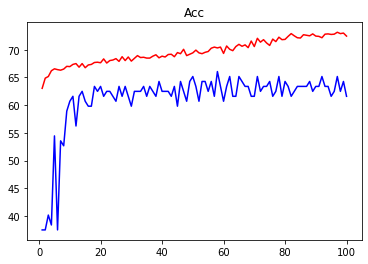

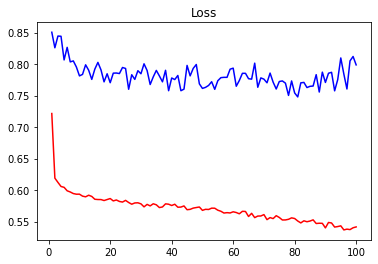

Testing Model


100%|██████████| 14/14 [00:00<00:00, 267.70it/s]


acc = 80.36


2024-06-07 11:10:23.227076: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-06-07 11:10:23.227115: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-06-07 11:10:23.227670: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: model
2024-06-07 11:10:23.230327: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-06-07 11:10:23.230347: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: model
2024-06-07 11:10:23.234124: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-06-07 11:10:23.235632: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-06-07 11:10:23.276224: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: model
2024-06-07 11:10:23.291119: I tensorflow

Successfully convert tflite float


2024-06-07 11:10:23.879952: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-06-07 11:10:23.879991: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-06-07 11:10:23.880234: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: model
2024-06-07 11:10:23.882346: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-06-07 11:10:23.882372: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: model
2024-06-07 11:10:23.887109: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-06-07 11:10:23.929292: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: model
2024-06-07 11:10:23.948176: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 67941 microseconds.
Summary on the non-c

Successfully convert tflite quant
30 5
84 84 112
testing with model/float_model.tflite


100%|██████████| 896/896 [00:00<00:00, 2763.03it/s]


result acc = 70.09
testing with model/quant_model.tflite


100%|██████████| 896/896 [00:00<00:00, 2629.72it/s]


result acc = 74.33


In [9]:
batch_size = 8
learning_rate = 1e-3
epochs = 100

output_class = 7
save_dir = Path("./")
input_shape, train_dataset, valid_dataset, test_dataset = dataset_preproccessed("../c30_e5_dataset.csv", batch_size, [0.9, 0.05, 0.05], output_class)
# input_shape, train_dataset, valid_dataset, test_dataset = pseudo_dataset_preproccessed(3000, 15, batch_size, [0.9, 0.05, 0.05], output_class)

m = model([input_shape], output_class, learning_rate)
m.build((batch_size , input_shape))
m._model.summary()

train_info = []
max_acc = 0
for epoch in range(epochs):
    epoch_info = train_one_epoch(m, train_dataset, valid_dataset, max_acc, save_dir)
    max_acc = max(epoch_info[2], max_acc)
    train_info.append(list(epoch_info))

show_train_results(train_info , save_dir)
testing_model(test_dataset, save_dir, save_dir)
save_model_tflite_quant(save_dir / "model", valid_dataset)

input_shape, train_dataset, valid_dataset, test_dataset = dataset_preproccessed("../c30_e5_dataset.csv", 1, [0.3, 0.3, 0.4], output_class)
test_tflite_model(save_dir / "model" / "float_model.tflite", test_dataset)
test_tflite_model(save_dir / "model" / "quant_model.tflite", test_dataset)

!xxd -i {save_dir}/model/quant_model.tflite > model/model.cc
# !echo -ne "#include \"model_data_quant.h\"\nalignas(8)\n" > model/model_data_quant.h
!cat model/model.cc > model/model_data_quant.h
!sed -i -E 's/(unsigned\s.*\s).*(_len|\[\])/const \1model\2/g' model/model_data_quant.h
     